1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

2. Load and Preprocess Data

In [2]:
# Load data
file_path = "Datasets/Cleaned_Walmart_Data.csv"
df = pd.read_csv(file_path)

# Getting actual weeks
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df['Week'] = df['Date'].dt.isocalendar().week
df.drop(columns=['Date'], inplace=True)
    
# Remove $ and commas from all string columns and turns them into float
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace(r'[\$,]', '', regex=True).str.strip().astype(float)


3. Exploratory Data Analysis

In [3]:
print("First 5 Rows:\n", df.head())
print("\nMissing Values:\n", df.isnull().sum())
print("\nSummary Statistics:\n", df.describe())

First 5 Rows:
    Store  Day  Month  Year  Weekly_Sales  Holiday_Flag  Temperature_(C)  \
0      1    5      2  2010    1643690.90             0             5.73   
1      1   12      2  2010    1641957.44             1             3.62   
2      1   19      2  2010    1611968.17             0             4.41   
3      1   26      2  2010    1409727.59             0             8.13   
4      1    5      3  2010    1554806.68             0             8.06   

   Fuel_Price     CPI  Unemployment  Week  
0        2.57  211.10          8.11     5  
1        2.55  211.24          8.11     6  
2        2.51  211.29          8.11     7  
3        2.56  211.32          8.11     8  
4        2.63  211.35          8.11     9  

Missing Values:
 Store              0
Day                0
Month              0
Year               0
Weekly_Sales       0
Holiday_Flag       0
Temperature_(C)    0
Fuel_Price         0
CPI                0
Unemployment       0
Week               0
dtype: int64

Summary

4. Feature Selection

In [4]:
target = 'Weekly_Sales'
# We make a list comprehension for the training features
features = [col for col in df.columns if col != target]

5. Split Data

In [5]:
X = df[features]
y = df[target]

# Splittng the whole dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=5)
# Splittng the temp into validation and testing
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=5)

print(f"Train: {X_train.shape}, Validation: {X_valid.shape}, Test: {X_test.shape}")

Train: (4087, 10), Validation: (876, 10), Test: (876, 10)


6. Model Training

In [6]:
# Initialize models
rf_model = RandomForestRegressor(random_state=5)
xgb_model = XGBRegressor(learning_rate=0.1, random_state=5, early_stopping_rounds=10)
lgbm_model = LGBMRegressor(learning_rate=0.1, random_state=5)

# Train models
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
lgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1078
[LightGBM] [Info] Number of data points in the train set: 4087, number of used features: 10
[LightGBM] [Info] Start training from score 1043842.639956


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


7. Model Evaluation

In [7]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

# Validate models
rf_preds = rf_model.predict(X_valid)
xgb_preds = xgb_model.predict(X_valid)
lgbm_preds = lgbm_model.predict(X_valid)

rf_mae, rf_rmse, rf_r2 = evaluate_model(y_valid, rf_preds)
xgb_mae, xgb_rmse, xgb_r2 = evaluate_model(y_valid, xgb_preds)
lgbm_mae, lgbm_rmse, lgbm_r2 = evaluate_model(y_valid, lgbm_preds)

print(f"{'Random Forest':<15} MAE: {rf_mae:10.2f}, RMSE: {rf_rmse:10.2f}, R²: {rf_r2:.4f}")
print(f"{'XGBoost':<15} MAE: {xgb_mae:10.2f}, RMSE: {xgb_rmse:10.2f}, R²: {xgb_r2:.4f}")
print(f"{'LightGBM':<15} MAE: {lgbm_mae:10.2f}, RMSE: {lgbm_rmse:10.2f}, R²: {lgbm_r2:.4f}")


Random Forest   MAE:   55546.64, RMSE:  104570.18, R²: 0.9616
XGBoost         MAE:   49117.84, RMSE:   76880.15, R²: 0.9792
LightGBM        MAE:   46506.84, RMSE:   70489.74, R²: 0.9825


8. Model Comparison Visualization

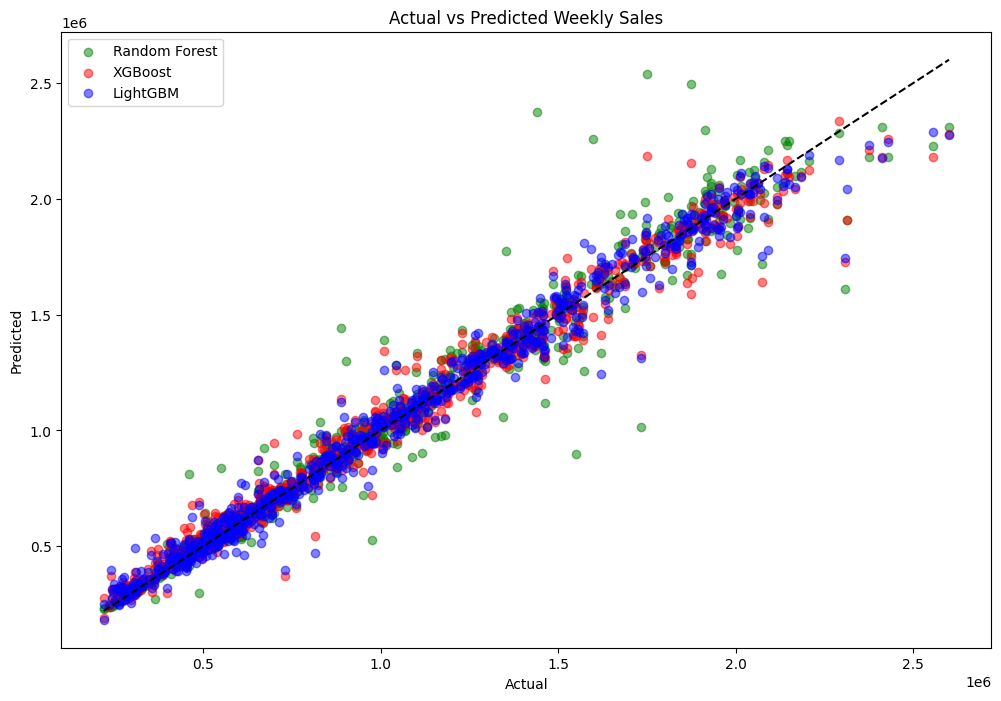

In [8]:
plt.figure(figsize=(12, 8))
plt.scatter(y_valid, rf_preds, label='Random Forest', alpha=0.5, color='green')
plt.scatter(y_valid, xgb_preds, label='XGBoost', alpha=0.5, color='red')
plt.scatter(y_valid, lgbm_preds, label='LightGBM', alpha=0.5, color='blue')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Weekly Sales')
plt.legend()
plt.savefig('models_performance.png')
plt.show()

9. Final Training (Train + Validation)

In [9]:
X_final = pd.concat([X_train, X_valid])
y_final = pd.concat([y_train, y_valid])
lgbm_model.fit(X_final, y_final)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1081
[LightGBM] [Info] Number of data points in the train set: 4963, number of used features: 10
[LightGBM] [Info] Start training from score 1039555.063369


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


10. Final Model Testing

In [10]:
best_model = lgbm_model
y_test_preds = best_model.predict(X_test)

test_mae, test_rmse, test_r2 = evaluate_model(y_test, y_test_preds)
print("\nFinal Test Set Performance (LightGBM):")
print(f"MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, R²: {test_r2:.4f}")


Final Test Set Performance (LightGBM):
MAE: 45396.88, RMSE: 73954.18, R²: 0.9818


11. Feature Importance Plot

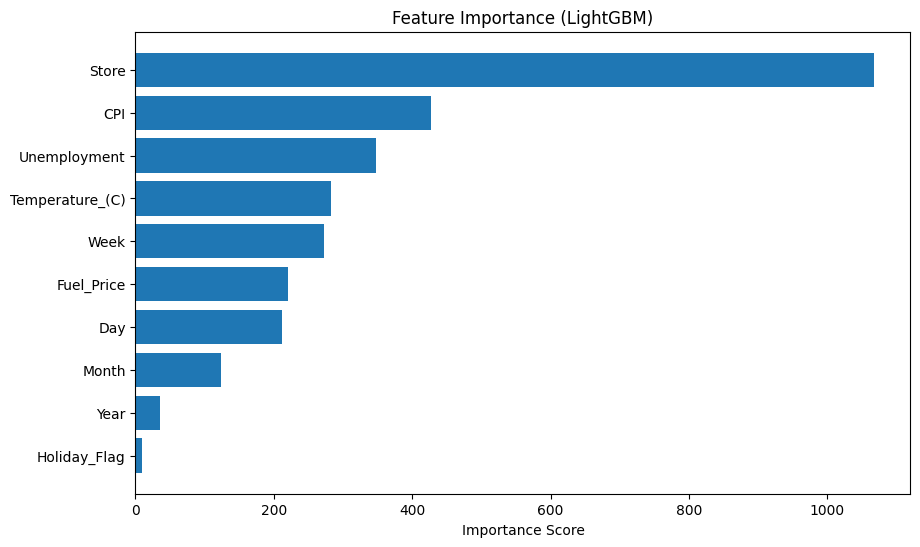

In [11]:
importances = lgbm_model.feature_importances_
sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.title('Feature Importance (LightGBM)')
plt.xlabel('Importance Score')
plt.savefig('feature_importance.png')
plt.show()

12. Save Model

In [12]:
joblib.dump(lgbm_model, 'walmart_best_model.pkl')
print("\n Model saved as 'walmart_best_model.pkl'")


 Model saved as 'walmart_best_model.pkl'
